In [1]:
%matplotlib notebook
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

$[E_f, E_b]^T = I_{\text{vac}, n} L_n I_{n-1} L_{n-1} \cdots I_1 L_1 I_{\text{sub}} [E_s, 0]^T$

So, for every layer we just need to define a vacuum interface matrix $I_{\text{vac},n}$, a layer matrix $L_n(t)$, and a transfer matrix $T_n = I_{n-1} L_{n-1} \cdots I_1 L_1 I_{\text{sub}}$

Note that $T_n = I_{n-1} L_{n-1}(t_f) T_{n-1}$

Reflectance should be $E_f = M_{00} E_s$ and $E_b = M_{10} E_s$ so $r = M_{10}/M_{00}$

In [2]:
class Material():
    def __init__(self, name):
        self.name = name
        self.N = {}
        
    def set_N_at_wavelength(self, wavelength, N):
        self.N[str(wavelength)] = N

class Layer():
    def __init__(self, material, thickness, growth_rate, previous_layer):
        self.thickness = thickness
        self.material = material
        self.N = self.material.N
        self.growth_rate = growth_rate
        self.previous_layer = previous_layer
        
        self.growth_time = thickness/growth_rate
        
    def set_transfer_matrix(self, transfer_matrix):
        self.transfer_matrix = transfer_matrix
        
    def set_vacuum_interface_matrix(self, vacuum_interface_matrix):
        self.vacuum_interface_matrix = vacuum_interface_matrix
        
    def set_layer_matrix(self, layer_matrix, t):
        self.layer_matrix = layer_matrix
        self.t = t
        
    def set_reflectance(self, reflectance):
        self.reflectance = reflectance

        
class Structure():
    def __init__(self, substrate_material, num_t = 1000):
        self.substrate_material = substrate_material
        self.num_t = num_t
        self.layers = []
        
        self.wavelength_scale = 1.0 # Assumes wavelengths and structure are both in nm
        # To change structure to angstrom, use use_angstroms_for_structure()
    
    def use_angstroms_for_structure(self):
        self.wavelength_scale = 0.1
    
    def set_wavelength(self, wavelength):
        self.wavelength = str(wavelength)
        
    def add_layer(self, material, thickness, growth_rate):
        if not self.layers:
            self.layers.append(Layer(material, 
                                     thickness, 
                                     growth_rate, 
                                     self.substrate_material))
        else:
            self.layers.append(Layer(material, 
                                     thickness, 
                                     growth_rate, 
                                     self.layers[-1].material))
            
    def calculate_transfer_matrices(self):
        
      
        for i in range(len(self.layers)):
            
            Ni = self.layers[i].material.N[self.wavelength]
            if i != 0:
                Nim1 = self.layers[i-1].material.N[self.wavelength]
            
            # Transfer matrices
            if i == 0:
                T0 = np.zeros((2,2), dtype = complex)
                T0[0,0] = Ni + self.substrate_material.N[self.wavelength]
                T0[0,1] = Ni - self.substrate_material.N[self.wavelength]
                T0[1,0] = T0[0,1]
                T0[1,1] = T0[0,0]

                T0 /= 2*Ni

                self.layers[0].set_transfer_matrix(T0)
                
            else:
                
                T = np.matmul(self.layers[i-1].layer_matrix[-1,:,:], 
                              self.layers[i-1].transfer_matrix)
                
                I = np.zeros((2,2), dtype = complex)
                I[0,0] = Ni + Nim1
                I[0,1] = Ni - Nim1
                I[1,0] = I[0,1]
                I[1,1] = I[0,0]
                
                I /= 2*Ni
                
                T = np.matmul(I, T)
                
                self.layers[i].set_transfer_matrix(T)
                
            # Vacuum interface matrices
            I = np.zeros((2,2), dtype = complex)
            I[0,0] = 1.0 + Ni
            I[0,1] = 1.0 - Ni
            I[1,0] = I[0,1]
            I[1,1] = I[0,0]

            I /= 2
            
            self.layers[i].set_vacuum_interface_matrix(I)
            
            # Layer matrices                                 

            d = np.linspace(0, self.layers[i].thickness, self.num_t)
            
            t = d/self.layers[i].growth_rate
            
            if i != 0:
                t += self.layers[i-1].t[-1]
            
            wl = float(self.wavelength)/self.wavelength_scale

            exp_fact = np.exp(1j*2*np.pi*Ni*d/wl)
            
            L = np.zeros((self.num_t,2,2), dtype = complex)
            
            L[:,0,0] = exp_fact
            L[:,0,1] = 0.0 + 1j*0
            L[:,1,0] = 0.0 + 1j*0
            L[:,1,1] = 1/exp_fact
            
            self.layers[i].set_layer_matrix(L,t)
    
    def calculate_reflectance(self, wavelength):
        
        self.set_wavelength(wavelength)
        
        self.calculate_transfer_matrices()
        
        t_total = np.array([])
        R_total = np.array([])
        
        for layer in self.layers:
            M = np.zeros((self.num_t,2,2), dtype = complex)
            
            M = np.matmul(layer.layer_matrix, layer.transfer_matrix)
            M = np.matmul(layer.vacuum_interface_matrix, M)
            
            r = M[:,1,0]/M[:,0,0]
            
            R = np.abs(r)**2
            
            layer.set_reflectance(R)
        
            t_total = np.concatenate((t_total, layer.t))
            R_total = np.concatenate((R_total, layer.reflectance))
            
        return t_total, R_total

In [3]:
# Set up materials

GaAs = Material('GaAs')
AlAs = Material('AlAs')

GaAs.set_N_at_wavelength(950.3, 3.7575 - 1j*0.1070)
AlAs.set_N_at_wavelength(950.3, 3.047 - 1j*0.00)

GaAs.set_N_at_wavelength(469.5, 4.667 - 1j*1.594)
AlAs.set_N_at_wavelength(469.5, 3.7341 - 1j*0.1022)


Layer thicknesses:
GaAs: 632.27 ang
AlAs: 3898.51 ang


<IPython.core.display.Javascript object>


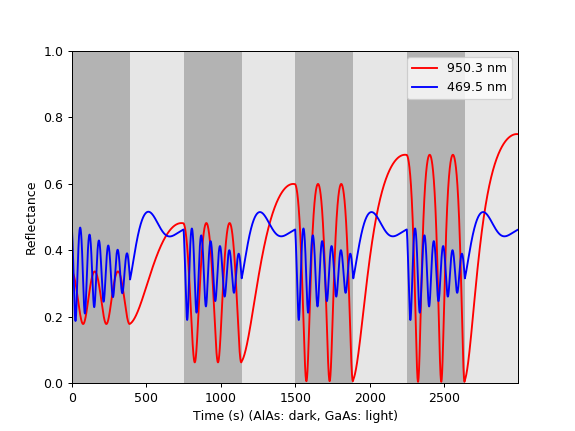

(0, 2996.3772269485758)

In [7]:
#### Define structure ####



# Use angstroms for structure and growth rate but nm for wavelength


wl = 950.3
wl_factor = {"AlAs": 2*0.5 + 0.25, "GaAs": 0*0.5 + 0.25}

L = {"AlAs": wl_factor["AlAs"]*wl/AlAs.N[str(wl)].real,
     "GaAs": wl_factor["GaAs"]*wl/GaAs.N[str(wl)].real}

print("Layer thicknesses:")
for mat in L:
    print('{}: {:.2f} ang'.format(mat, L[mat]*10))

G = {"AlAs": 1, "GaAs": 0.176}

num_repeats = 4

struct = Structure(substrate_material = GaAs)
for i in range(num_repeats):
    struct.add_layer(AlAs, L["AlAs"], G["AlAs"])
    struct.add_layer(GaAs, L["GaAs"], G["GaAs"])
# Add layers (material, thickness, growth_rate)

#struct.use_angstroms_for_structure() 
#struct.add_layer(AlAs, 769, 1.0)
#struct.add_layer(GaAs, 3278, 1.0)
#struct.add_layer(AlAs, 769, 0.77)
#struct.add_layer(GaAs, 1980, 0.65)

#### Calculate reflectance ####
t = {}
R = {}

wavelengths = [950.3, 469.5]

for wl in wavelengths:
    t[str(wl)], R[str(wl)] = struct.calculate_reflectance(wavelength = wl)

#### Plot reflectance ####

fig, ax = plt.subplots()

for layer in struct.layers:
    #tf = layer.t[-1]
    #ax.plot([tf,tf], [0,1], '--k', label = '')
    if layer.material.name == 'AlAs':
        color = (0.7, 0.7, 0.7)
    elif layer.material.name == 'GaAs':
        color = (0.9, 0.9, 0.9)
    rect = patches.Rectangle(([layer.t[0], 0]), layer.t[-1] - layer.t[0], 1.0, facecolor = color, lw = 0.0)
    ax.add_patch(rect)


colors = {'950.3': 'r', '469.5': 'b'}
for wavelength in wavelengths:
    wl = str(wavelength)
    ax.plot(t[wl], R[wl], label = wl + ' nm', color = colors[wl])
    
    
ax.legend()
ax.set_xlabel('Time (s) (AlAs: dark, GaAs: light)')
ax.set_ylabel('Reflectance')
ax.set_ylim([0,1])
ax.set_xlim([0,t[wl][-1]])

### Structure design

AlAs thickness: 2339.10 Angstrom
GaAs thickness: 3161.34 Angstrom

Alternate between AlAs and GaAs